## Problem Statement

The aim is to evaluate a large dataset of policing activities collected over a few years in order to discover patterns and find homogeneous categories of incidents. The goal is to reduce the dataset's complexity, produce meaningful visualizations that capture its key features, investigate dimensionality reduction strategies, and provide descriptive statistics for each cluster.

## Objectives and Goals

* **Data Exploration:** Understand the structure, variables, and patterns within the policing dataset.
* **Cluster Identification:** Group similar policing incidents into homogeneous clusters.
* **Visualization Creation:** Develop visualizations that illustrate the main characteristics and clusters within the dataset.
* **Descriptive Statistics:** Provide statistical insights into each cluster.

# Notebook Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Data Exploration and Preprocessing

### Load data

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.1)
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
51708,932648,616230,MALE,WAINWRIGHT ST,C11,5,9/22/13 0:00,9/22/13 0:00,YES,B(Black),...,NO DATA ENTERED,10739.0,62601,16,YVSF,NaN,B(Black),19,4719,NO DATA ENTERED
142902,863242,547242,MALE,50 ANNUNCIATION RD,B2,3,1/26/12 0:00,1/26/12 0:00,YES,B(Black),...,NO DATA ENTERED,86201.0,81408,16,YVSF,NaN,B(Black),24,163,NO DATA ENTERED
29675,710970,521901,MALE,120 PLEASANT ST,C11,5,4/22/11 0:00,4/22/11 0:00,NO,NO DATA ENTERED,...,NO DATA ENTERED,10739.0,11631,16,YVSF,BH,NO DATA ENTERED,23,3560,NO DATA ENTERED
48187,928571,612132,MALE,6 FRAZER ST,E18,10,9/7/13 0:00,9/7/13 0:00,NaN,B(Black),...,NO DATA ENTERED,10132.0,99722,16,YVSF,NaN,B(Black),32,1778,NO DATA ENTERED
104971,970788,653059,MALE,715 TREMONT ST,D4,8,11/10/14 0:00,11/10/14 0:00,NO,B(Black),...,OTHER,NaN,93870,8,D4,NaN,B(Black),25,4562,Dorchester


In [5]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (15223, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INCI

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15223 entries, 51708 to 150145
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    15223 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  15223 non-null  object
 2   SUBJECT_GENDER                                15223 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  15223 non-null  object
 4   LOCATION_DISTRICT                             15223 non-null  object
 5   LOCATION_DISTRICT.1                           15223 non-null  object
 6   INCIDENT_DATE                                 15223 non-null  object
 7   INCIDENT_TIME                                 15223 non-null  object
 8   SUBJECT_DETAILS                               13104 non-null  object
 9   SUBJECT_RACE                                  15223 non-null  object
 10

### Data Cleaning

In [7]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0, 'OTHER', 'OTHERS'], value=np.nan, inplace=True)

In [8]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                     22
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        0
LOCATION_DISTRICT                                   4
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                  2276
SUBJECT_RACE                                      621
SUBJECT_DETAILS.1                                1301
SUBJECT_DETAILS.2                                2500
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
SEARCH_CONDUCTED                                13151
SEARCH_REASON                                   11731
INCIDENT_REASON                                  4688
INCIDENT_REASON.1                                   0


In [9]:
# dropping columns where the NaN values were more than 4000
for feature in df.columns:
    if df[feature].isnull().sum() > 4000:
        df.drop([feature], axis=1, inplace=True)
        
# dropping columns where the unique values were more than 750
for feature in df.columns:
    
    if feature != 'LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION' and feature != 'INCIDENT_DATE':
        
        if len(df[feature].unique()) > 750:
            df.drop([feature], axis=1, inplace=True)

In [10]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
51708,MALE,WAINWRIGHT ST,C11,5,9/22/13 0:00,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),19
142902,MALE,50 ANNUNCIATION RD,B2,3,1/26/12 0:00,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",NaN,86201.0,16,YVSF,B(Black),24
29675,MALE,120 PLEASANT ST,C11,5,4/22/11 0:00,NO,NaN,Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,NaN,23
48187,MALE,6 FRAZER ST,E18,10,9/7/13 0:00,NaN,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),32
104971,MALE,715 TREMONT ST,D4,8,11/10/14 0:00,NO,B(Black),Dark,IO,NO,DISTURBANCE,F,NaN,8,D4,B(Black),25


In [11]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    22
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
LOCATION_DISTRICT.1                                0
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2276
SUBJECT_RACE                                     621
SUBJECT_DETAILS.2                               2500
UNKNOWN_FIELD_TYPE                                 0
UNKNOWN_FIELD_TYPE.1                               0
INCIDENT_REASON.1                                  0
DISPOSITION                                      899
OFFICER_SUPERVISOR                              1596
OFFICER_ASSIGNMENT                                 0
OFFICER_ASSIGNMENT.1                              43
OFFICER_RACE                                     621
OFFICER_AGE                                       23
dtype: int64


In [12]:
df.shape

(15223, 17)

In [13]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
51708,MALE,WAINWRIGHT ST,C11,5,9/22/13 0:00,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),19
142902,MALE,50 ANNUNCIATION RD,B2,3,1/26/12 0:00,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",NaN,86201.0,16,YVSF,B(Black),24
29675,MALE,120 PLEASANT ST,C11,5,4/22/11 0:00,NO,NaN,Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,NaN,23
48187,MALE,6 FRAZER ST,E18,10,9/7/13 0:00,NaN,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),32
104971,MALE,715 TREMONT ST,D4,8,11/10/14 0:00,NO,B(Black),Dark,IO,NO,DISTURBANCE,F,NaN,8,D4,B(Black),25


In [14]:
df.shape

(15223, 17)

In [15]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
51708,MALE,WAINWRIGHT ST,C11,5,9/22/13 0:00,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),19
142902,MALE,50 ANNUNCIATION RD,B2,3,1/26/12 0:00,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",NaN,86201.0,16,YVSF,B(Black),24
29675,MALE,120 PLEASANT ST,C11,5,4/22/11 0:00,NO,NaN,Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,NaN,23
48187,MALE,6 FRAZER ST,E18,10,9/7/13 0:00,NaN,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),32
104971,MALE,715 TREMONT ST,D4,8,11/10/14 0:00,NO,B(Black),Dark,IO,NO,DISTURBANCE,F,NaN,8,D4,B(Black),25


In [16]:
df.duplicated().value_counts()

False    15163
True        60
Name: count, dtype: int64

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    22
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
LOCATION_DISTRICT.1                                0
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2259
SUBJECT_RACE                                     618
SUBJECT_DETAILS.2                               2486
UNKNOWN_FIELD_TYPE                                 0
UNKNOWN_FIELD_TYPE.1                               0
INCIDENT_REASON.1                                  0
DISPOSITION                                      895
OFFICER_SUPERVISOR                              1592
OFFICER_ASSIGNMENT                                 0
OFFICER_ASSIGNMENT.1                              43
OFFICER_RACE                                     618
OFFICER_AGE                                       23
dtype: int64


In [19]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
LOCATION_DISTRICT.1                             0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
UNKNOWN_FIELD_TYPE                              0
UNKNOWN_FIELD_TYPE.1                            0
INCIDENT_REASON.1                               0
DISPOSITION                                     0
OFFICER_SUPERVISOR                              0
OFFICER_ASSIGNMENT                              0
OFFICER_ASSIGNMENT.1                            0
OFFICER_RACE                                    0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [20]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [21]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,WAINWRIGHT ST,C11,5,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),19,2013,September
1,MALE,50 ANNUNCIATION RD,B2,3,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",F,86201.0,16,YVSF,B(Black),24,2012,January
2,MALE,120 PLEASANT ST,C11,5,NO,B(Black),Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),23,2011,April
3,MALE,6 FRAZER ST,E18,10,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),32,2013,September
4,MALE,715 TREMONT ST,D4,8,NO,B(Black),Dark,IO,NO,DISTURBANCE,F,11756.0,8,D4,B(Black),25,2014,November


In [22]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [23]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    3975
2013    3458
2011    3456
2014    3349
2015     925
Name: count, dtype: int64

In [24]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'SEXUAL OFFENDER': ['SEXUAL', 'OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC', 'DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD', 'PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT', 'RUN'],
    'SEARCH WARRANT': ['SEARCH', 'WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY', 'ORDINANCES'],
    'MISSING PERSON': ['MISSING'],
    'DISORDERLY': ['DISORDERLY', 'UNNATURAL', 'LACIVIOUS'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 4
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 4].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [25]:
len(df['INCIDENT_REASON.1'].value_counts())

32

In [26]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-19': range(15, 20),
    '20-29': range(20, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [27]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,WAINWRIGHT ST,C11,5,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),15-19,2013,September
1,MALE,50 ANNUNCIATION RD,B2,3,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",F,86201.0,16,YVSF,B(Black),20-29,2012,January
2,MALE,120 PLEASANT ST,C11,5,NO,B(Black),Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),20-29,2011,April
3,MALE,6 FRAZER ST,E18,10,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),30-39,2013,September
4,MALE,715 TREMONT ST,D4,8,NO,B(Black),Dark,IO,NO,DISTURBING,F,11756.0,8,D4,B(Black),20-29,2014,November


In [28]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()

    match = re.search(r'[^0-9]+$', modified_address)
    if match:
        old_street_name = address
        new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
        street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# # Find values with counts less than or equal to 2
# infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 2].index

# # Replace those infrequent values with 'OTHERS'
# df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [29]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,C11,5,YES,B(Black),Dark,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),15-19,2013,September,WAINWRIGHT ST
1,MALE,B2,3,YES,B(Black),Dark,I,NO,"INVESTIGATE, PERSON",F,86201.0,16,YVSF,B(Black),20-29,2012,January,ANNUNCIATION RD
2,MALE,C11,5,NO,B(Black),Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),20-29,2011,April,PLEASANT ST
3,MALE,E18,10,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,10132.0,16,YVSF,B(Black),30-39,2013,September,FRAZER ST
4,MALE,D4,8,NO,B(Black),Dark,IO,NO,DISTURBING,F,11756.0,8,D4,B(Black),20-29,2014,November,TREMONT ST


In [30]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 19
Number of unique values in LOCATION_DISTRICT.1 column: 35
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in SUBJECT_DETAILS.2 column: 8
Number of unique values in UNKNOWN_FIELD_TYPE column: 22
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 32
Number of unique values in DISPOSITION column: 7
Number of unique values in OFFICER_SUPERVISOR column: 206
Number of unique values in OFFICER_ASSIGNMENT column: 40
Number of unique values in OFFICER_ASSIGNMENT.1 column: 21
Number of unique values in OFFICER_RACE column: 6
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 1764


In [31]:
df.shape

(15163, 18)

### Data Encoding

In [32]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
LOCATION_DISTRICT.1        object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
UNKNOWN_FIELD_TYPE         object
UNKNOWN_FIELD_TYPE.1       object
INCIDENT_REASON.1          object
DISPOSITION                object
OFFICER_SUPERVISOR         object
OFFICER_ASSIGNMENT         object
OFFICER_ASSIGNMENT.1       object
OFFICER_RACE               object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [33]:
encoded_df = df.copy()

for feature in encoded_df.columns:
    encoded_df[feature] = encoded_df[feature].astype(str)

label_encoder = LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

### Dimensionality Reduction

<Axes: >

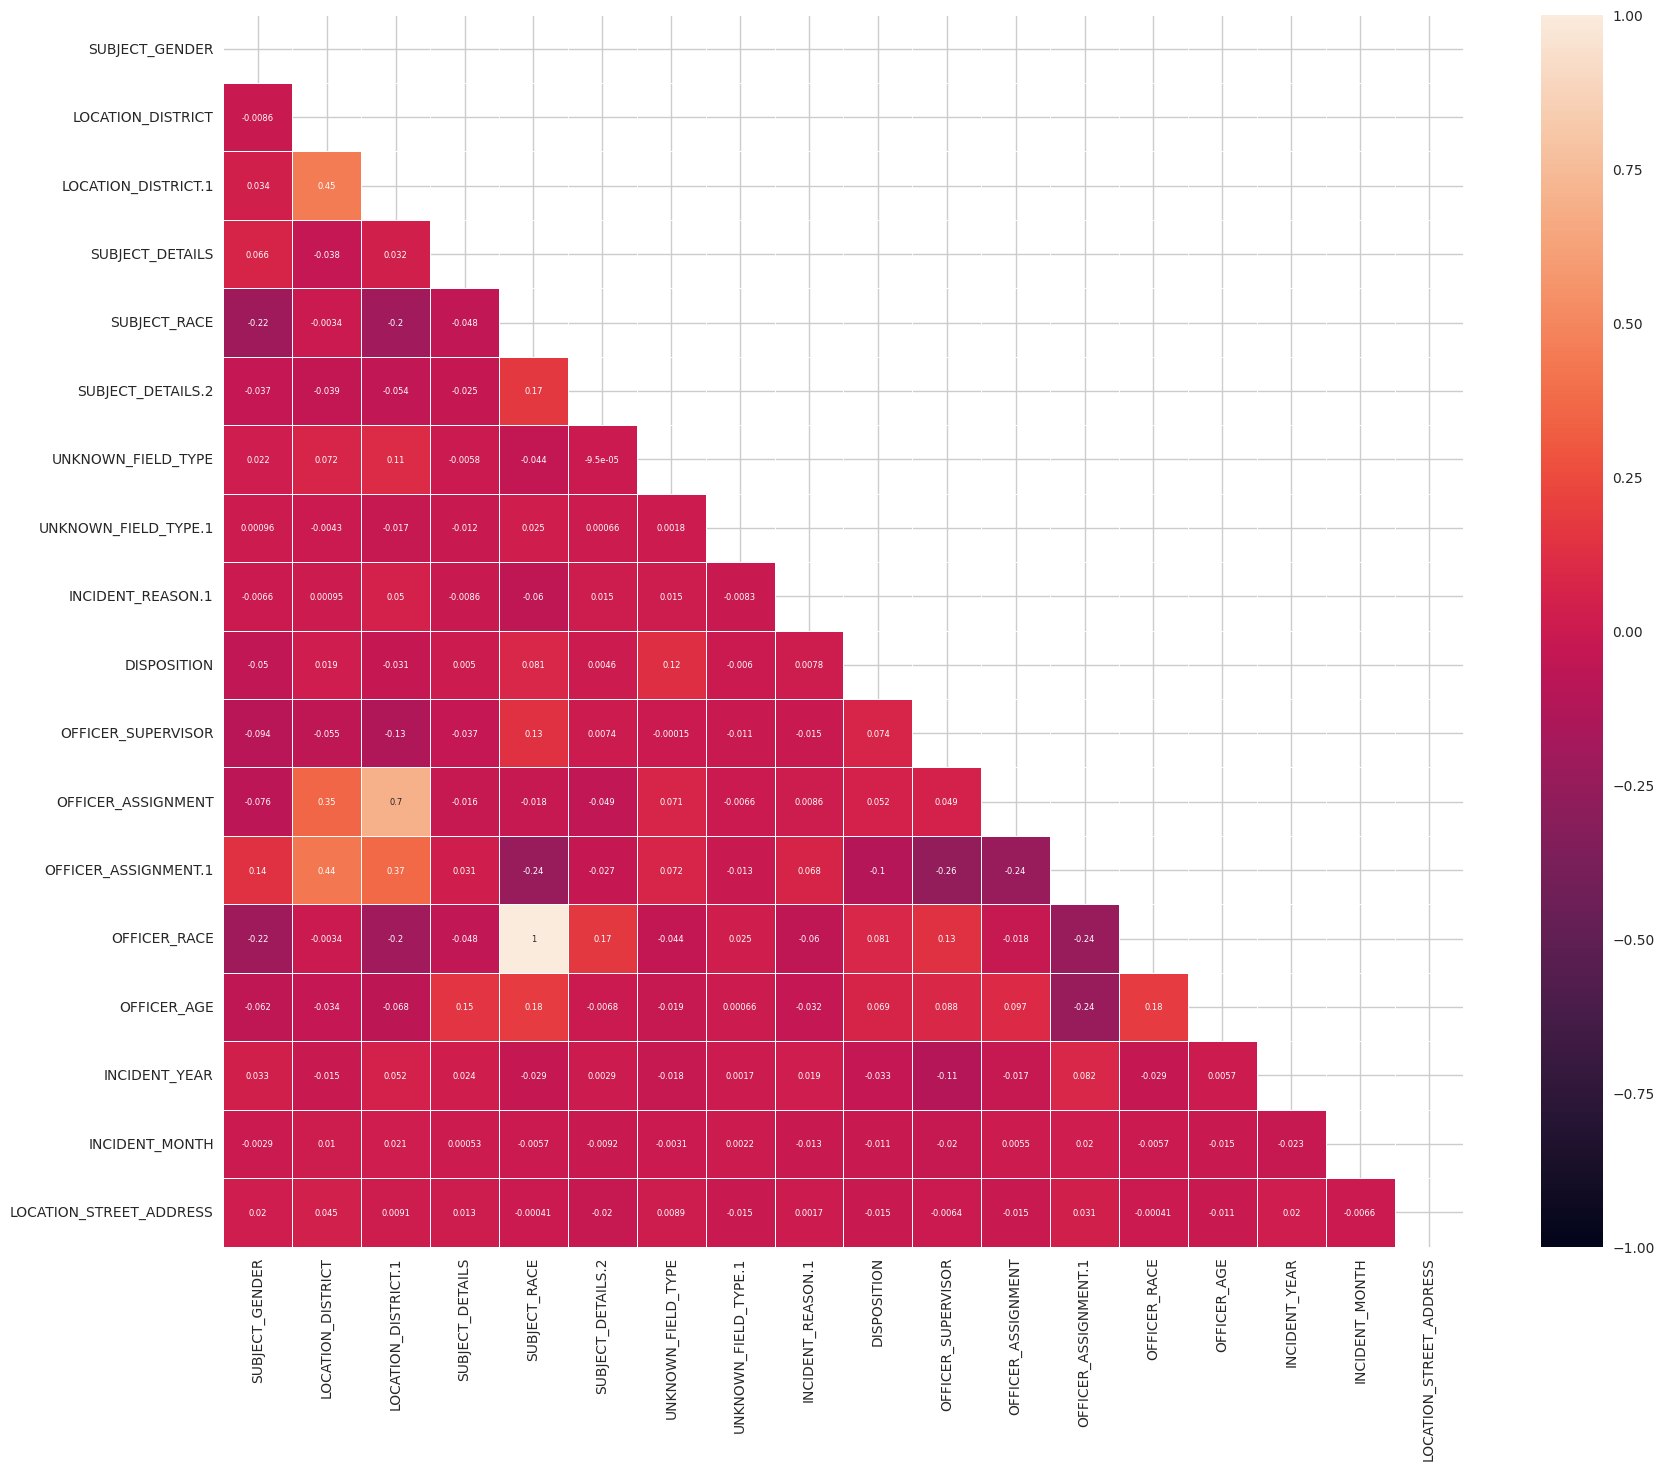

In [34]:
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(encoded_df.corr(), dtype=bool))

sns.heatmap(encoded_df.corr(), vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={'size': 6}, linewidths=0.7)

In [35]:
# dropping the correlated columns
corr_mat = encoded_df.corr()
threshold = 0.7

for i in range(len(corr_mat.columns)):
    for n in range(i):
        if abs(corr_mat.iloc[i, n]) >= threshold:
            encoded_df.drop(columns=[corr_mat.columns[i], corr_mat.columns[n]], inplace=True)

encoded_df.shape

(15163, 14)

In [36]:
one_hot_encoded_data = pd.get_dummies(df[encoded_df.columns], columns=encoded_df.columns, dtype=float) 
one_hot_encoded_data.head()

,SUBJECT_GENDER_FEMALE,SUBJECT_GENDER_MALE,LOCATION_DISTRICT_A1,LOCATION_DISTRICT_A15,LOCATION_DISTRICT_A7,LOCATION_DISTRICT_Auto,LOCATION_DISTRICT_B2,LOCATION_DISTRICT_B3,LOCATION_DISTRICT_BIKE,LOCATION_DISTRICT_BMP,...,LOCATION_STREET_ADDRESS_YAWKEY WY,LOCATION_STREET_ADDRESS_ZAKIM BRID ELIOT ST,LOCATION_STREET_ADDRESS_ZEIGLER ST,LOCATION_STREET_ADDRESS_` TREMONT ST,LOCATION_STREET_ADDRESS_a W DEDHAM ST,LOCATION_STREET_ADDRESS_b W DEDHAM ST,LOCATION_STREET_ADDRESS_s CHARLAME ST,LOCATION_STREET_ADDRESS_unk ANDREWS ST,LOCATION_STREET_ADDRESS_unk WASHINGTON ST,LOCATION_STREET_ADDRESS_unk WESTVILLE TR
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering

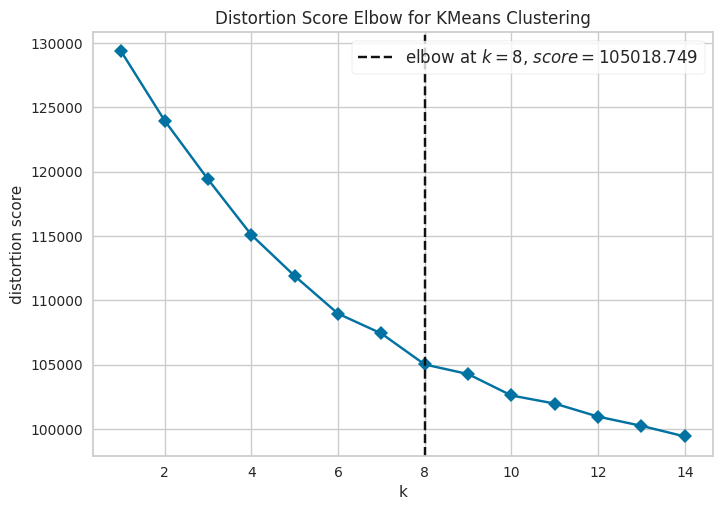

In [37]:
# Elbow Method to find optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 15), timings=False)
visualizer.fit(one_hot_encoded_data)
visualizer.show()

# Get optimal k from the Elbow method
optimal_k = visualizer.elbow_value_

In [38]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100).fit(one_hot_encoded_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

### Quality of Clusters

In [39]:
cluster_characteristics = []
size_of_clusters = []

for i in range(optimal_k):    
    cluster_data = one_hot_encoded_data[labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 1050, 'Avg Distance': 2.6558919952562823},
 {'Cluster': 1, 'Size': 1230, 'Avg Distance': 2.4710235819823287},
 {'Cluster': 2, 'Size': 1655, 'Avg Distance': 2.58420290770866},
 {'Cluster': 3, 'Size': 2350, 'Avg Distance': 2.5626579631452615},
 {'Cluster': 4, 'Size': 2825, 'Avg Distance': 2.9722050705026044},
 {'Cluster': 5, 'Size': 1494, 'Avg Distance': 2.3694699029660398},
 {'Cluster': 6, 'Size': 1766, 'Avg Distance': 2.6324660819822507},
 {'Cluster': 7, 'Size': 2793, 'Avg Distance': 2.501613287864006}]

In [40]:
silhouette_avg = silhouette_score(one_hot_encoded_data, kmeans.labels_)
print('Silhouette Score:', round(silhouette_avg, 4))

db_index = davies_bouldin_score(one_hot_encoded_data, kmeans.labels_)
print('Davies-Bouldin Index:', round(db_index, 4))

ch_score = calinski_harabasz_score(one_hot_encoded_data, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', round(ch_score, 4))

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', round(wcss, 4))

Silhouette Score: 0.0714
Davies-Bouldin Index: 3.5054
Calinski-Harabasz Index (Variance Ratio Criterion): 494.6634
Within-Cluster Sum of Squares (WCSS): 105293.9954


In [41]:
df['CLUSTERS'] = kmeans.labels_

In [42]:
def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[column] = df[column].mode()[0]
    
    return profiles

In [43]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

cluster_profile_df

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,,,,,,,,,,,,,
0,MALE,C11,5,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,8695.0,5,C11,B(Black),20-29,2011,February,DORCHESTER AV
1,MALE,D4,8,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,11756.0,8,D4,B(Black),20-29,2011,June,SHAWMUT AV
2,MALE,A1,1,YES,W(White),Med,I,NO,"INVESTIGATE, PERSON",F,8949.0,1,A1,W(White),20-29,2011,May,BOYLSTON ST
3,MALE,B2,3,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,11610.0,3,B2,B(Black),20-29,2013,May,BLUE HILL AV
4,MALE,C6,6,YES,W(White),Med,IO,NO,"INVESTIGATE, PERSON",F,8662.0,6,C6,W(White),20-29,2012,May,WASHINGTON ST
5,MALE,B3,4,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,11756.0,4,B3,B(Black),20-29,2012,May,BLUE HILL AV
6,MALE,B2,3,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,86124.0,16,YVSF,B(Black),15-19,2014,May,BLUE HILL AV
7,MALE,B2,3,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,86124.0,16,YVSF,B(Black),20-29,2014,May,BLUE HILL AV


### Cluster Visualization

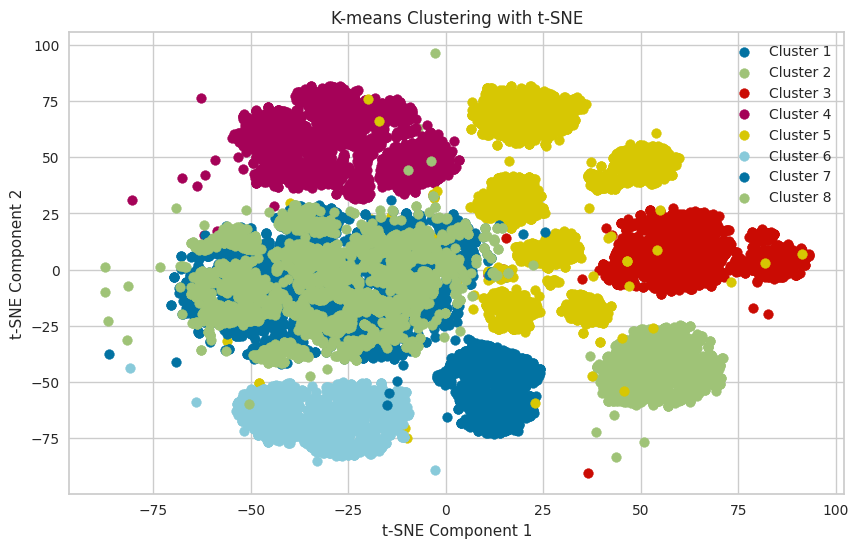

In [44]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(one_hot_encoded_data)

plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    plt.scatter(tsne_results[labels == i][:, 0], 
                tsne_results[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

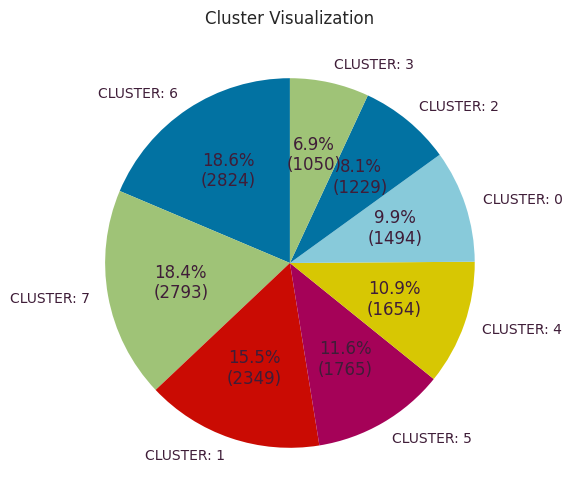

In [45]:
data = [len(df[df['CLUSTERS'] == feature]) for feature in df['CLUSTERS'].value_counts().index]
clusters = df['CLUSTERS'].unique()
labels = [f'CLUSTER: {clusters[i]}' for i in range(len(clusters))]

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(data, labels=labels, autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.title('Cluster Visualization')
plt.show()

# Exploratory Data Analysis (EDA)

### Gender and Race Distribution

Based on the dataset findings, the demographic breakdown of offenders indicates that approximately **88.3% are male**, with the remaining **11.7% being female**. The dataset illustrates that the majority of offenders fall within racial categories, notably Black **(8815 male and 741 female)**, White **(2617 male and 867 female)**, and Hispanic **(1786 male and 137 female)** groups.

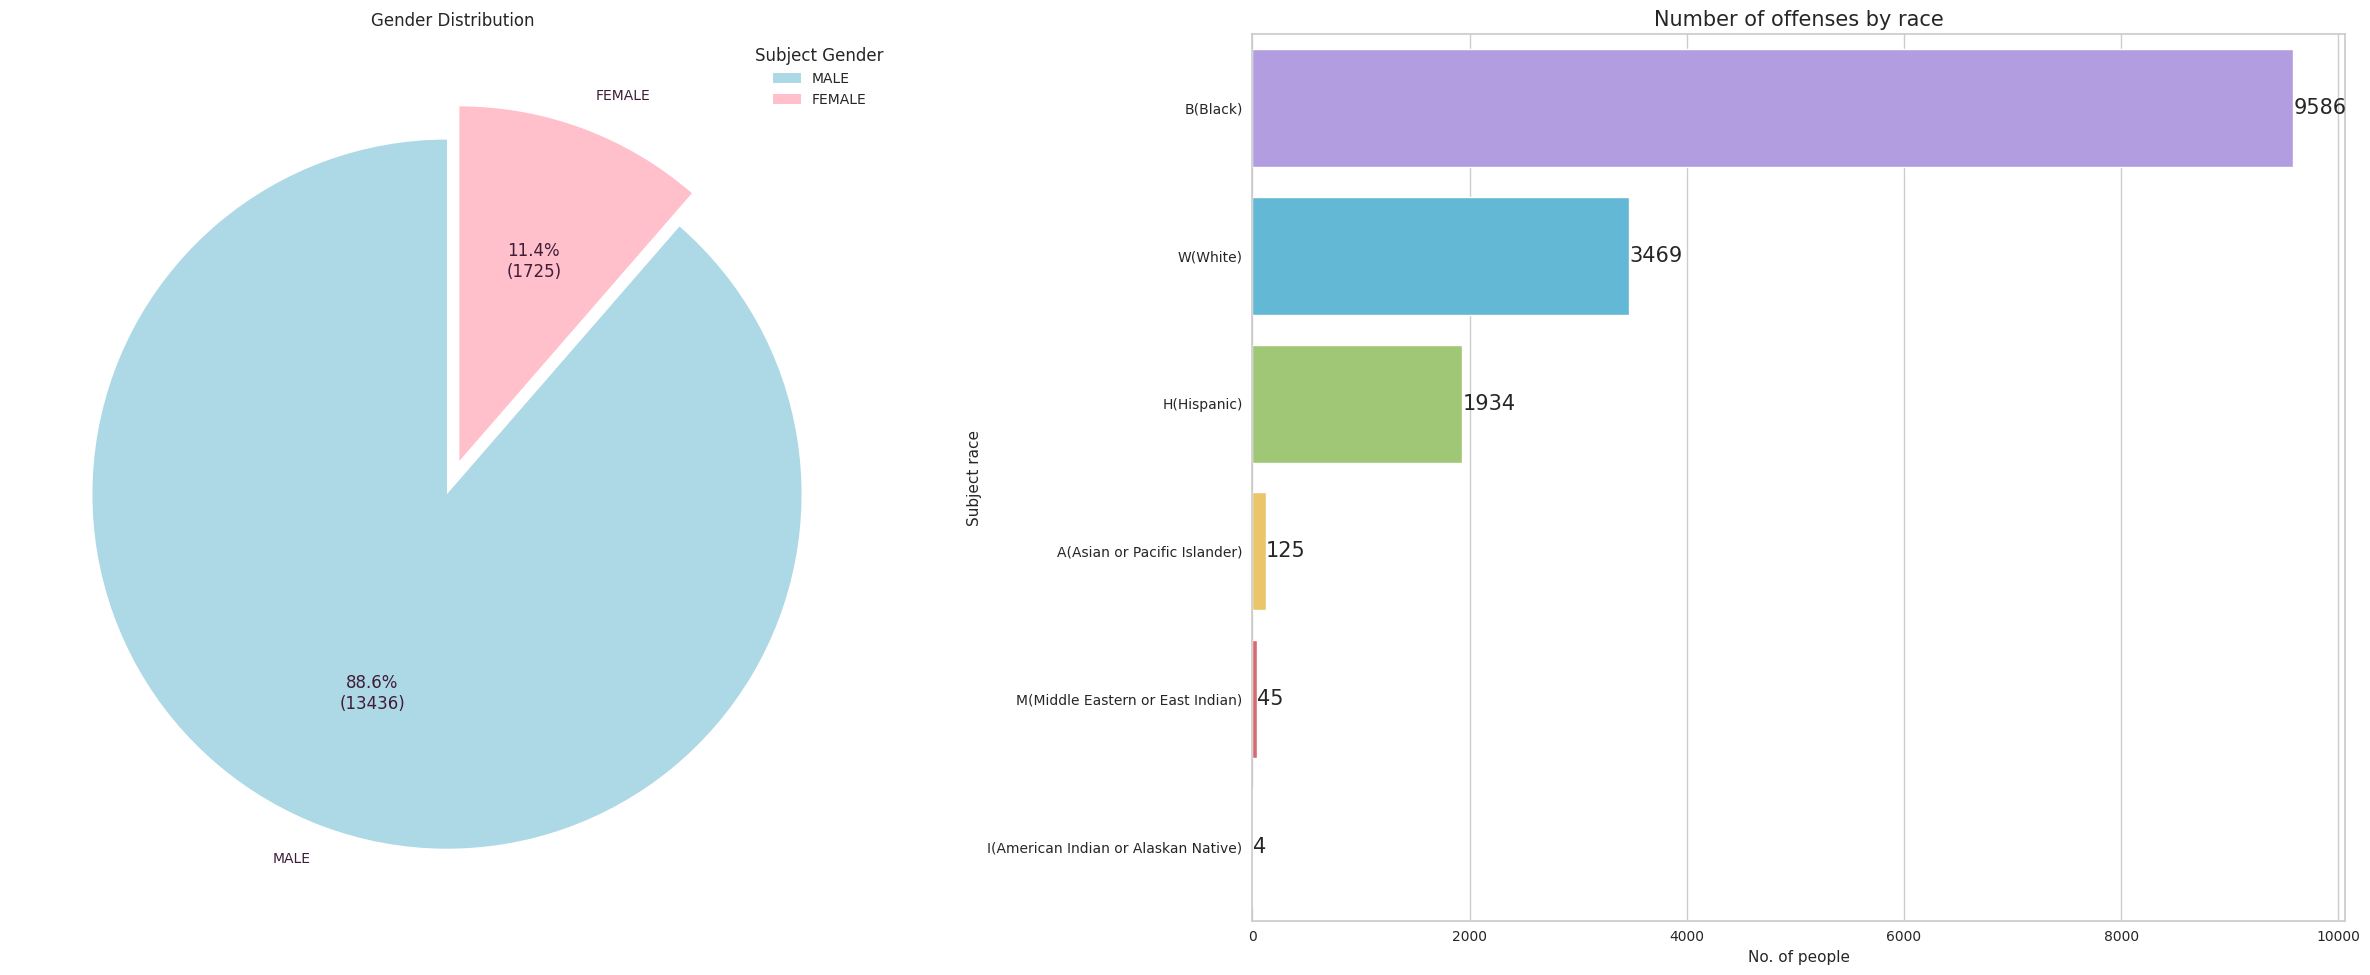

In [46]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

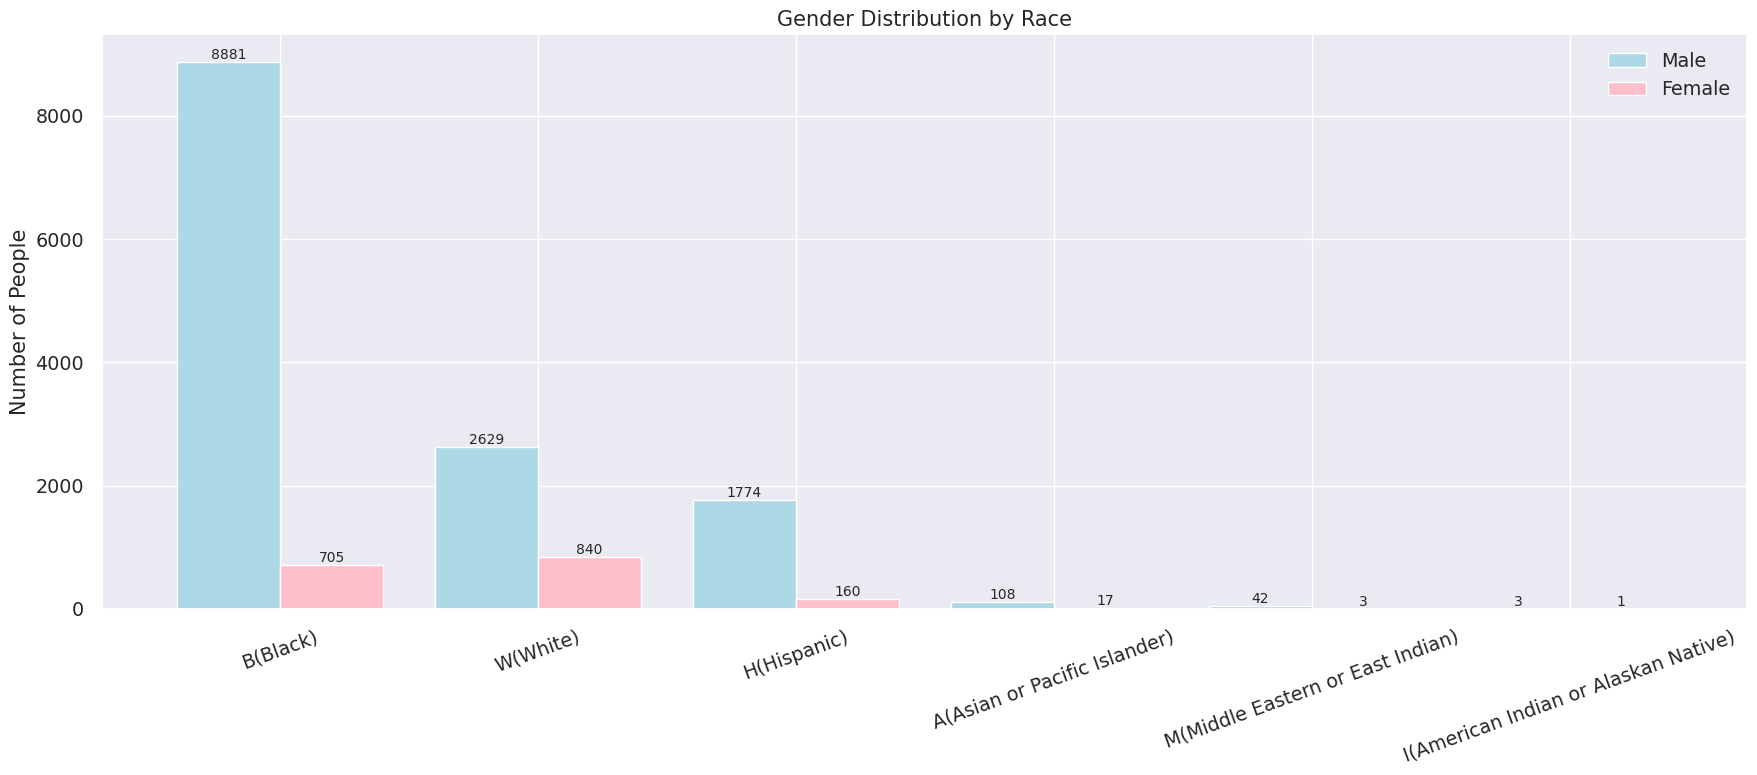

In [47]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().index

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
male_counts = male['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)
female_counts = female['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, male_counts, width, color=colors[0], label='Male')
plt.bar(x + width/2, female_counts, width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, male_counts[i], str(male_counts[i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, female_counts[i], str(female_counts[i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

The dataset provides insights into incidents that occurred between **2011 and 2015.** The distribution of incidents demonstrates that from **2011 to 2014**, there was a relatively consistent occurrence rate, ranging between **22% and 25%.** However, only **6.3%** of incidents were recorded in the year **2015**. Furthermore, the data highlights a seasonal trend, with a significant concentration of incidents happening during the **spring** months. Specifically, March recorded **1502 incidents**, April had **1388**, and May saw **1732 incidents**. The remaining incidents were distributed across the **summer** season, accounting for **3699**, **fall** with **3436**, and **winter** with **3386** occurrences. 

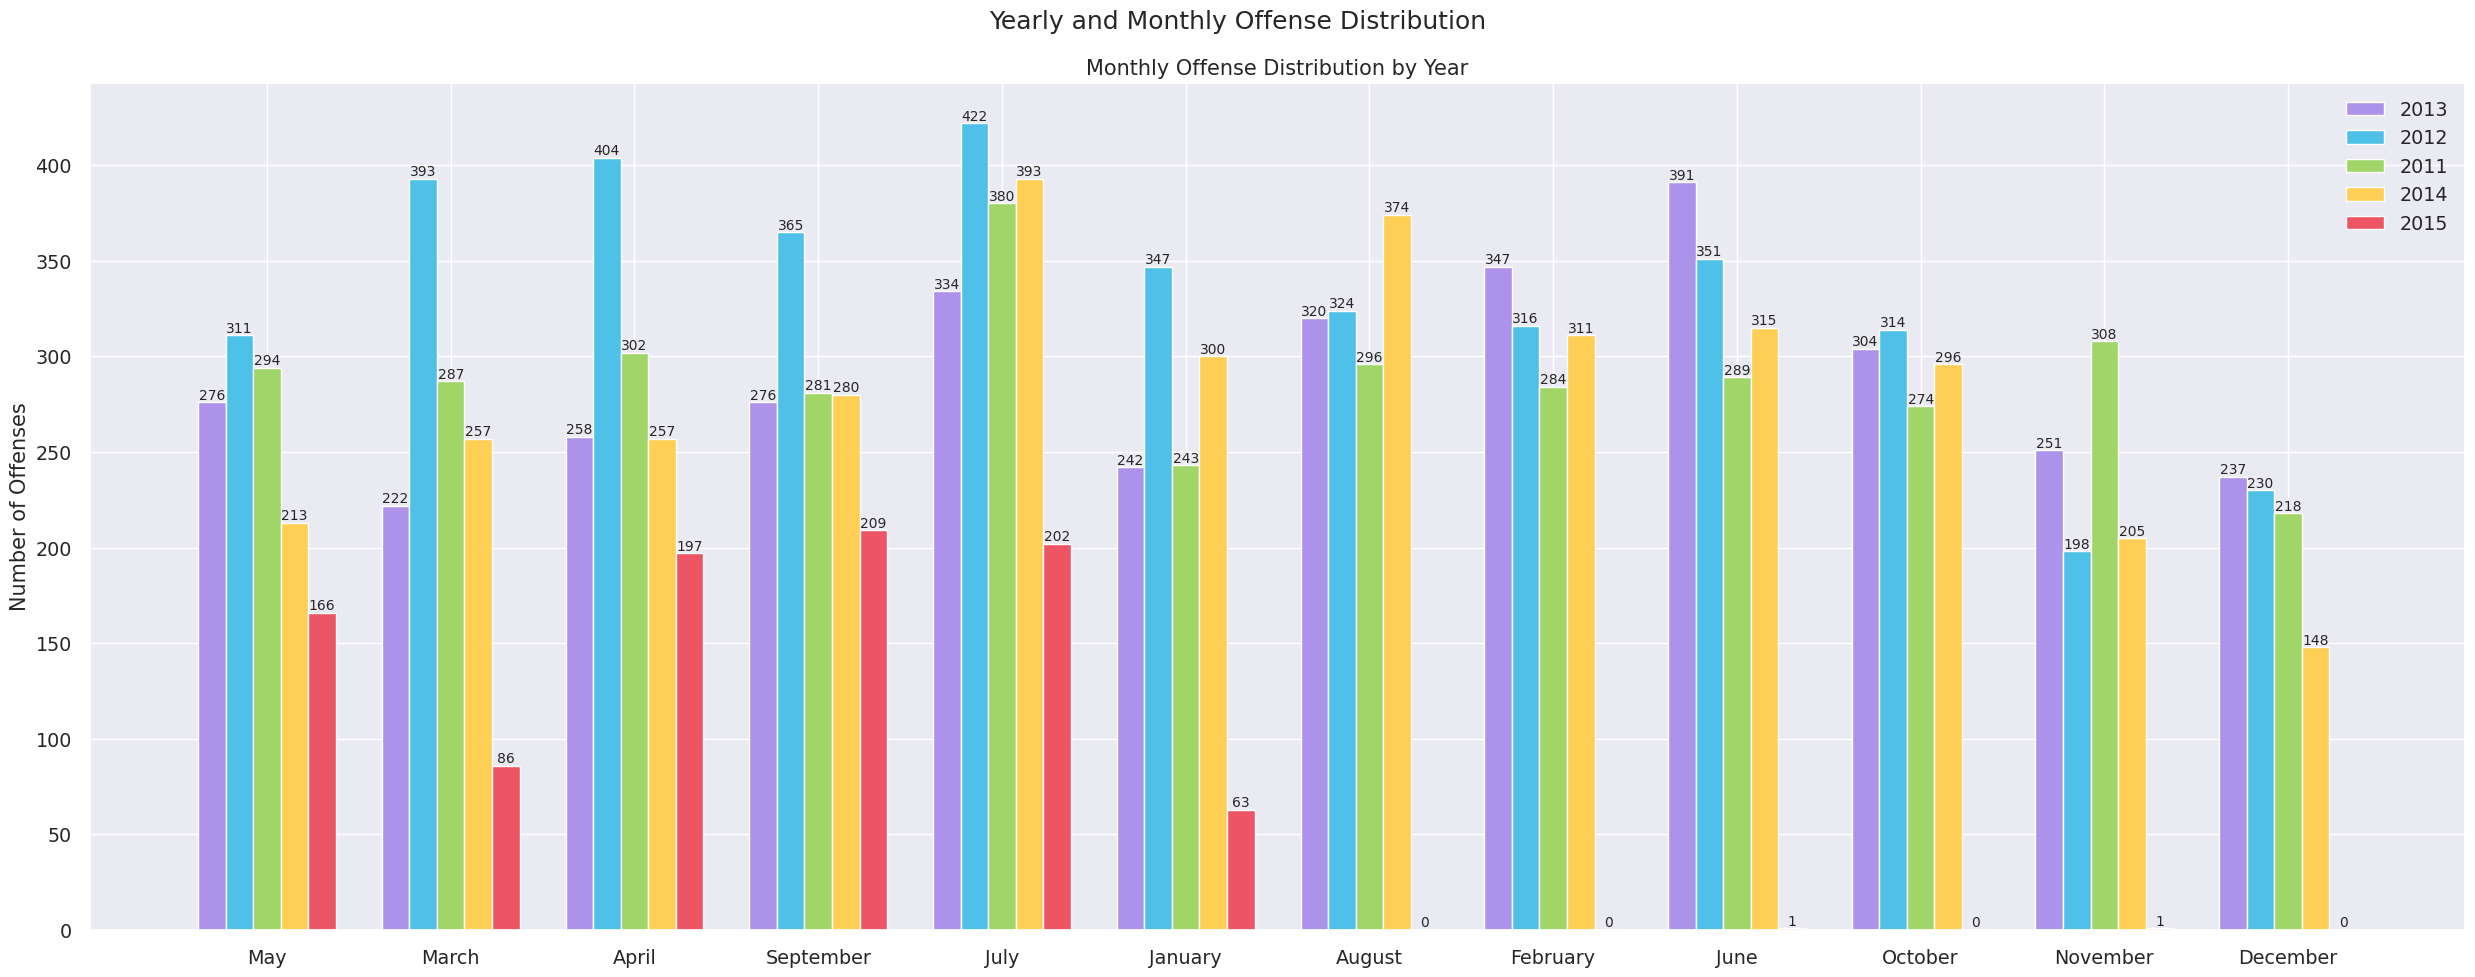

In [48]:
# Get unique years in your data
years_to_plot = df['INCIDENT_YEAR'].unique()

# Create a mapping from month names to their numeric values
month_name_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].map(month_name_to_number)  # Map month names to numbers
    value_counts = value.value_counts()

    # Create an empty list to store the counts for all 12 months
    monthly_counts = [0] * 12
    
    # Fill in the counts for the months that exist
    for month, count in value_counts.items():
        monthly_counts[month - 1] = count  # Subtract 1 to adjust for zero-based indexing

    values.append(monthly_counts)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(len(years_to_plot)):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(len(years_to_plot)):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().index
plt.xticks(x, order)
plt.ylabel("Number of Offenses")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

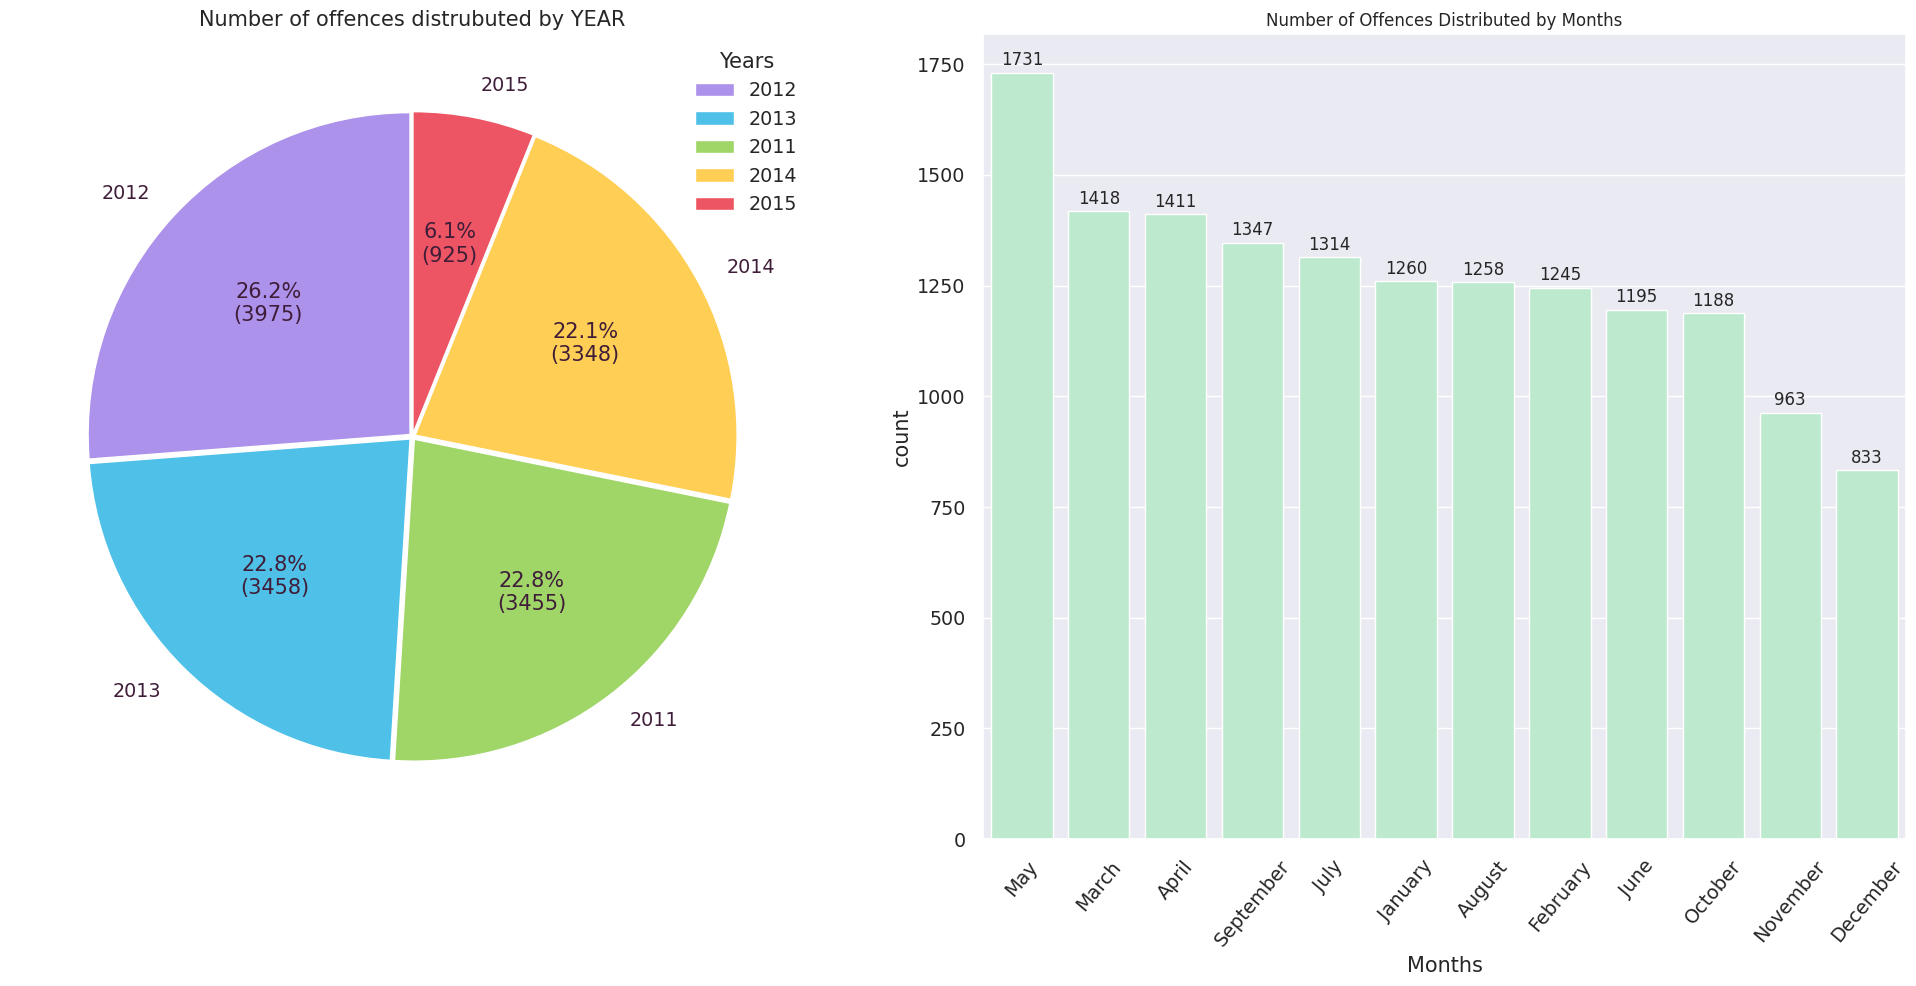

In [49]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

### Number of Offences Distributed by Location

Regarding the locations where the majority of offenses occurred, the dataset points out that **Washington St** (854 incidents), **Blue Hill Ave** (622 incidents), **Dorchester Ave** (370 incidents), **Boylston St** (354 incidents), and **Tremont St** (352 incidents) were among the areas with higher occurrences. Furthermore, the dataset highlights that Districts **B2** (3950 incidents), **B3** (2265 incidents), **C11** (1989 incidents), **D4** (1667 incidents), and **A1** (1540 incidents) registered a notable number of offenses.

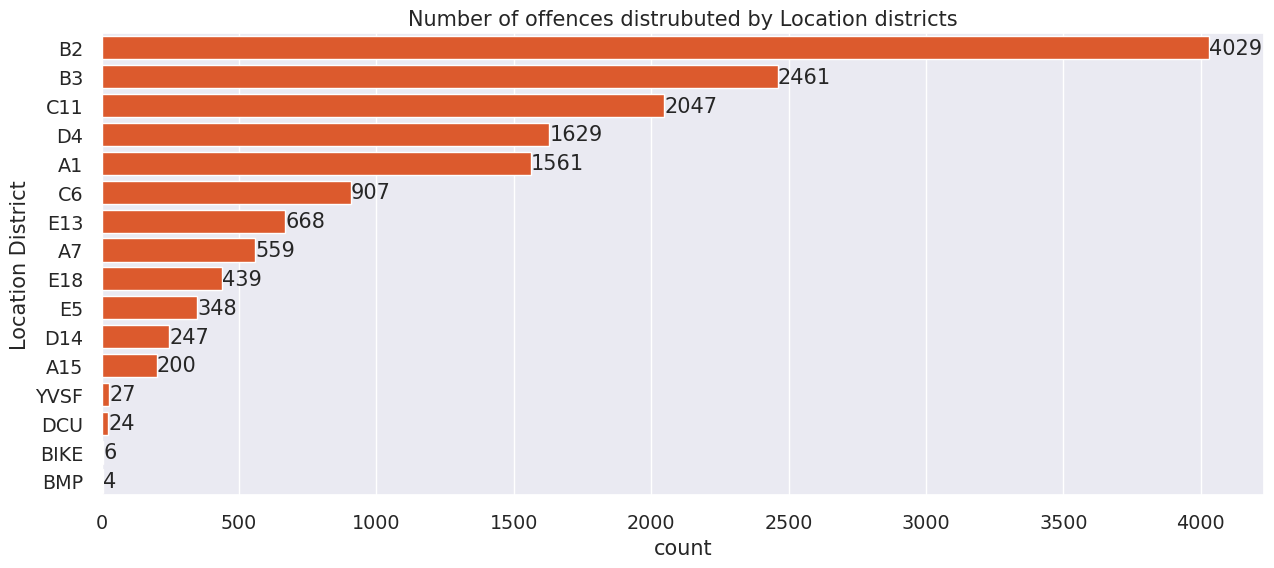

In [50]:
# Bar chart 1: Location district
plt.figure(figsize=(15, 6))
order = df['LOCATION_DISTRICT'].value_counts().index[0:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

plt.show()

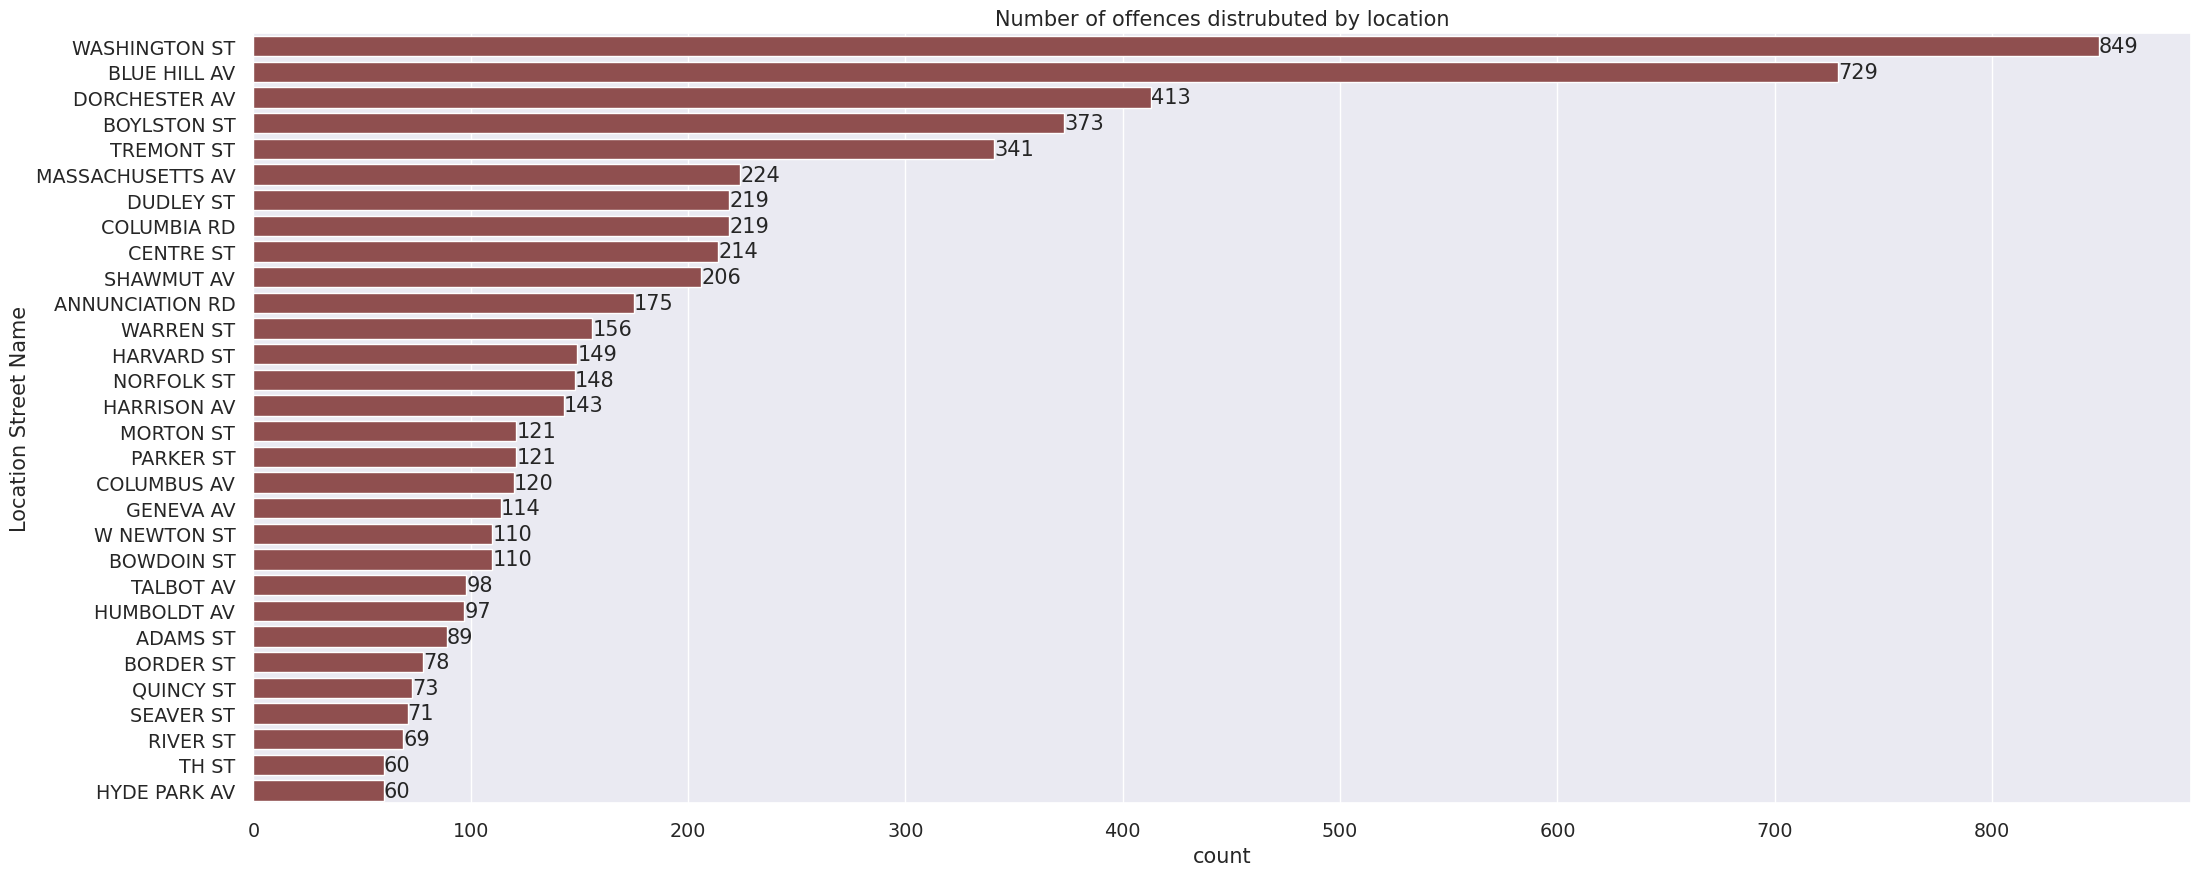

In [51]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

The two images presented provide a visual representation of officers' ages and their respective assignments. The data showcases that the predominant age brackets among officers are in their **twenties** (20-29 years), totaling **7242 individuals**, followed by those in their **thirties** (30-39 years), amounting to **2747**. In terms of assignments, a significant number of officers, approximately **4350**, are engaged in **YVSF** assignments. Additionally, **2311 officers** are assigned to **B2**, while **1618 officers** are allocated to **A1** duties.

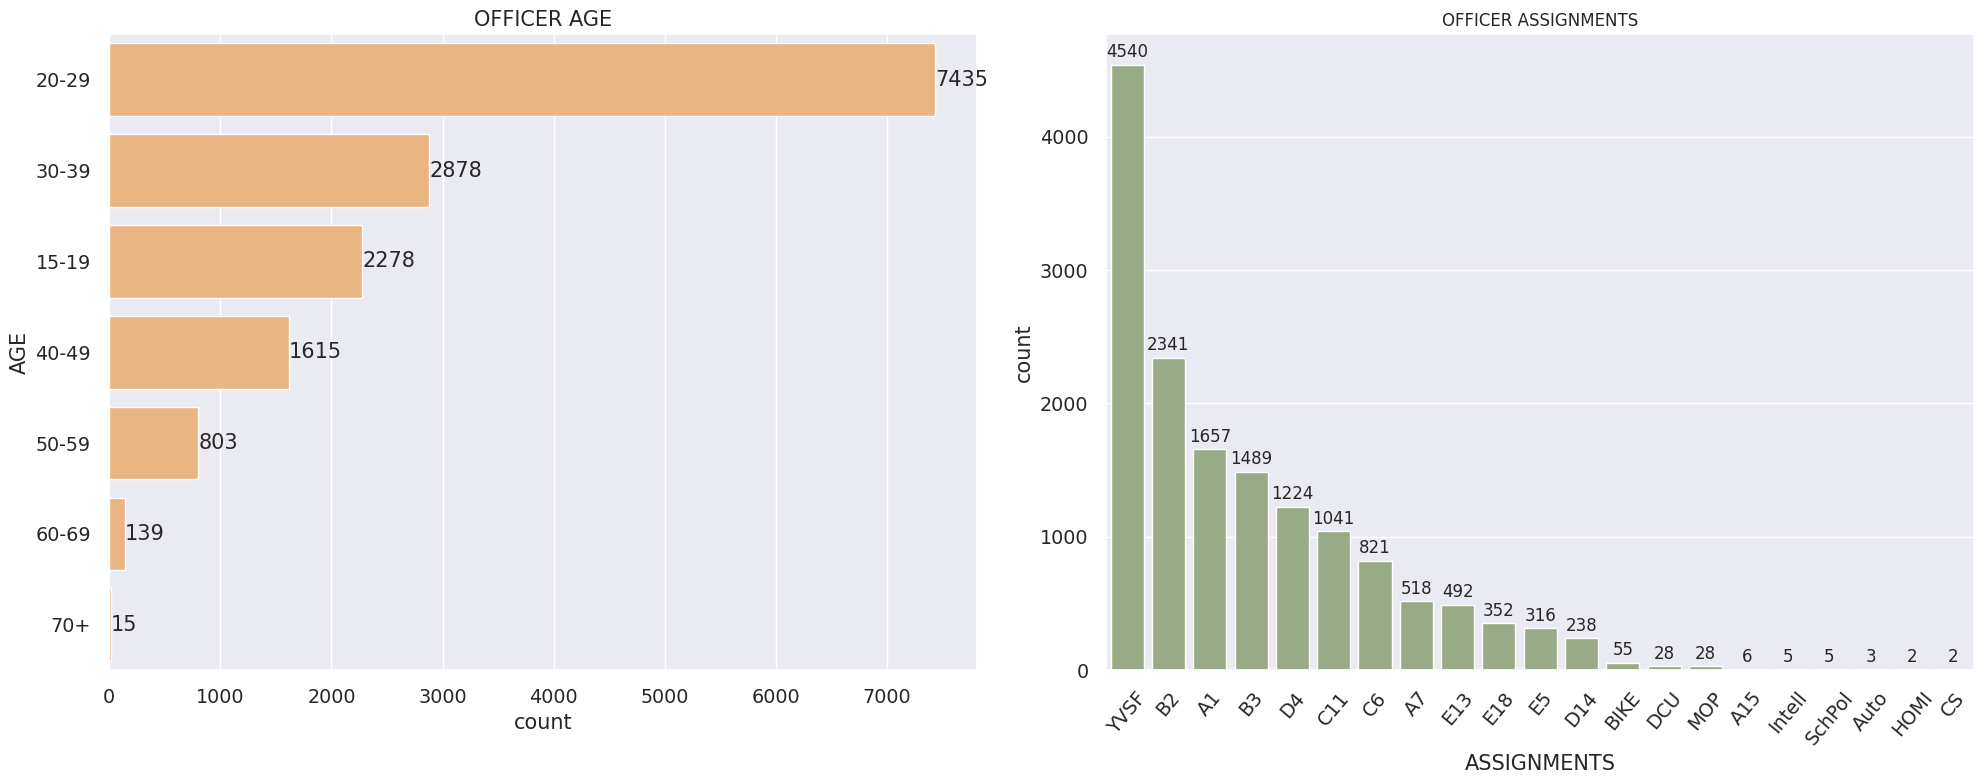

In [52]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

## Number of offenses distributed by incident reasons
Regarding the motives behind these incidents, the dataset indicates that the most frequent reasons were related to **investigating persons** (9071 incidents), followed by **VAL** (2089 incidents), **drug-related offenses** (585 incidents), **trespassing** (463 incidents), and **motor vehicle-related incident**s (424 incidents).

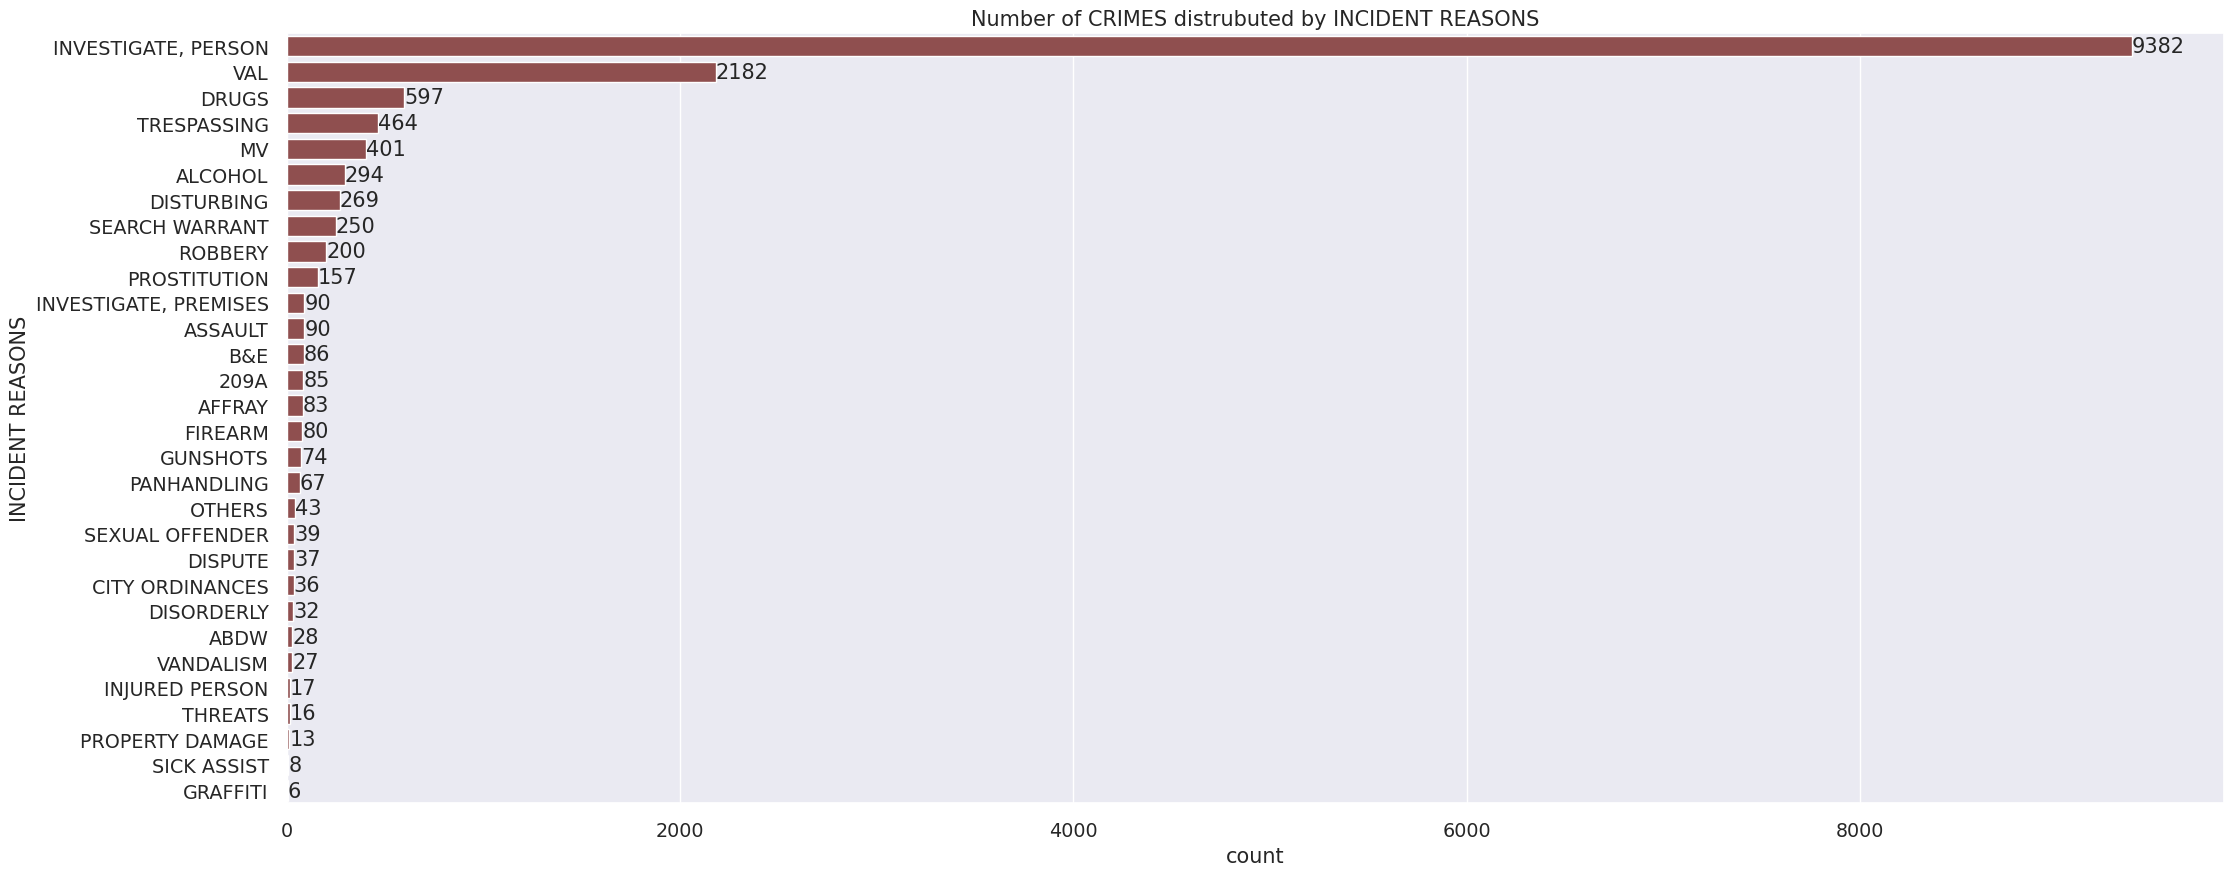

In [53]:
# Bar chart 1:
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()